# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('Data/bank_fin.csv', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def new_bal(row):
    row=str(row)
    while True:
        row=row.replace(',00','')
        row=row.replace('$','')
        row=row.replace(' ','')
        return float(row)
df['balance']=df['balance'].apply(new_bal)

<Axes: >

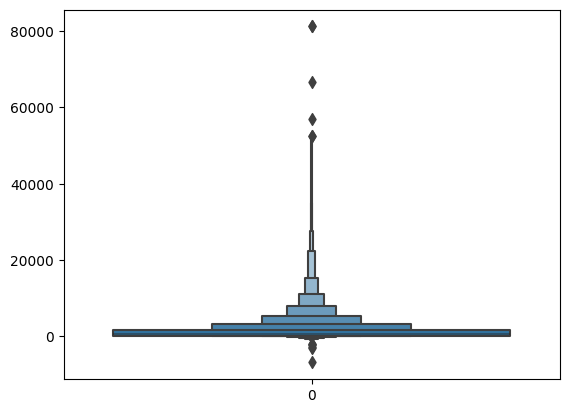

In [6]:
sns.boxenplot(df['balance'])

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [67]:
round(df['balance'].mean(),3)

1529.129

### Задание 4

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance']=df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
m_edu=df['education'].mode()[0]
m_job=df['job'].mode()[0]
df['job']=df['job'].apply(lambda x: m_job if x=='unknown' else x )
df['education']=df['education'].apply(lambda x: m_edu if x=='unknown' else x )

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [70]:
df['balance'].value_counts()

balance
 0.0       774
 1.0        39
 2.0        34
 3.0        34
 550.0      31
          ... 
 1641.0      1
 5517.0      1
 8332.0      1
 4859.0      1
-134.0       1
Name: count, Length: 3802, dtype: int64

In [8]:
df['job'].value_counts()[:1] # management 2636
df['education'].value_counts()[:1] #secondary 5973
df_new=df[(df['job']=='management') & (df['education']=='secondary')]
round(df_new['balance'].mean(),3)

1598.883

### Задание 6

In [9]:
# удалите все выбросы для признака balance
q1=df['balance'].quantile(0.25)
q3=df['balance'].quantile(0.75)
iqr=q3-q1
lower_bound=q1-1.5*iqr
upper_bound=q3+1.5*iqr
print(lower_bound,upper_bound)

-2241.0 4063.0


In [12]:
df_nb=df[(df['balance']>=lower_bound) & (df['balance']<=upper_bound)]
df_nb.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

In [16]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
df_nb[df_nb['deposit']=='yes'].shape[0]

4681

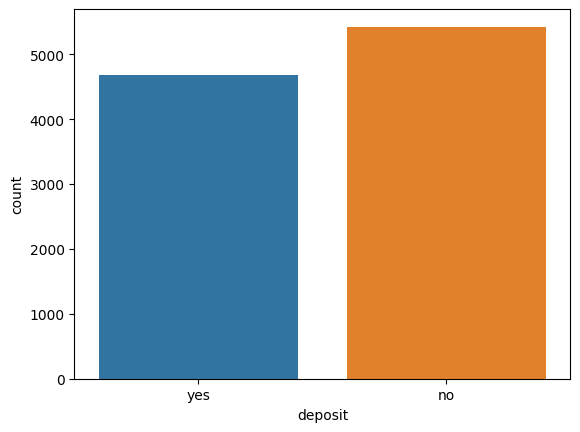

In [20]:
dfg= sns.countplot(x=df_nb['deposit'])

### Задания 2 и 3

In [17]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df_nb.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

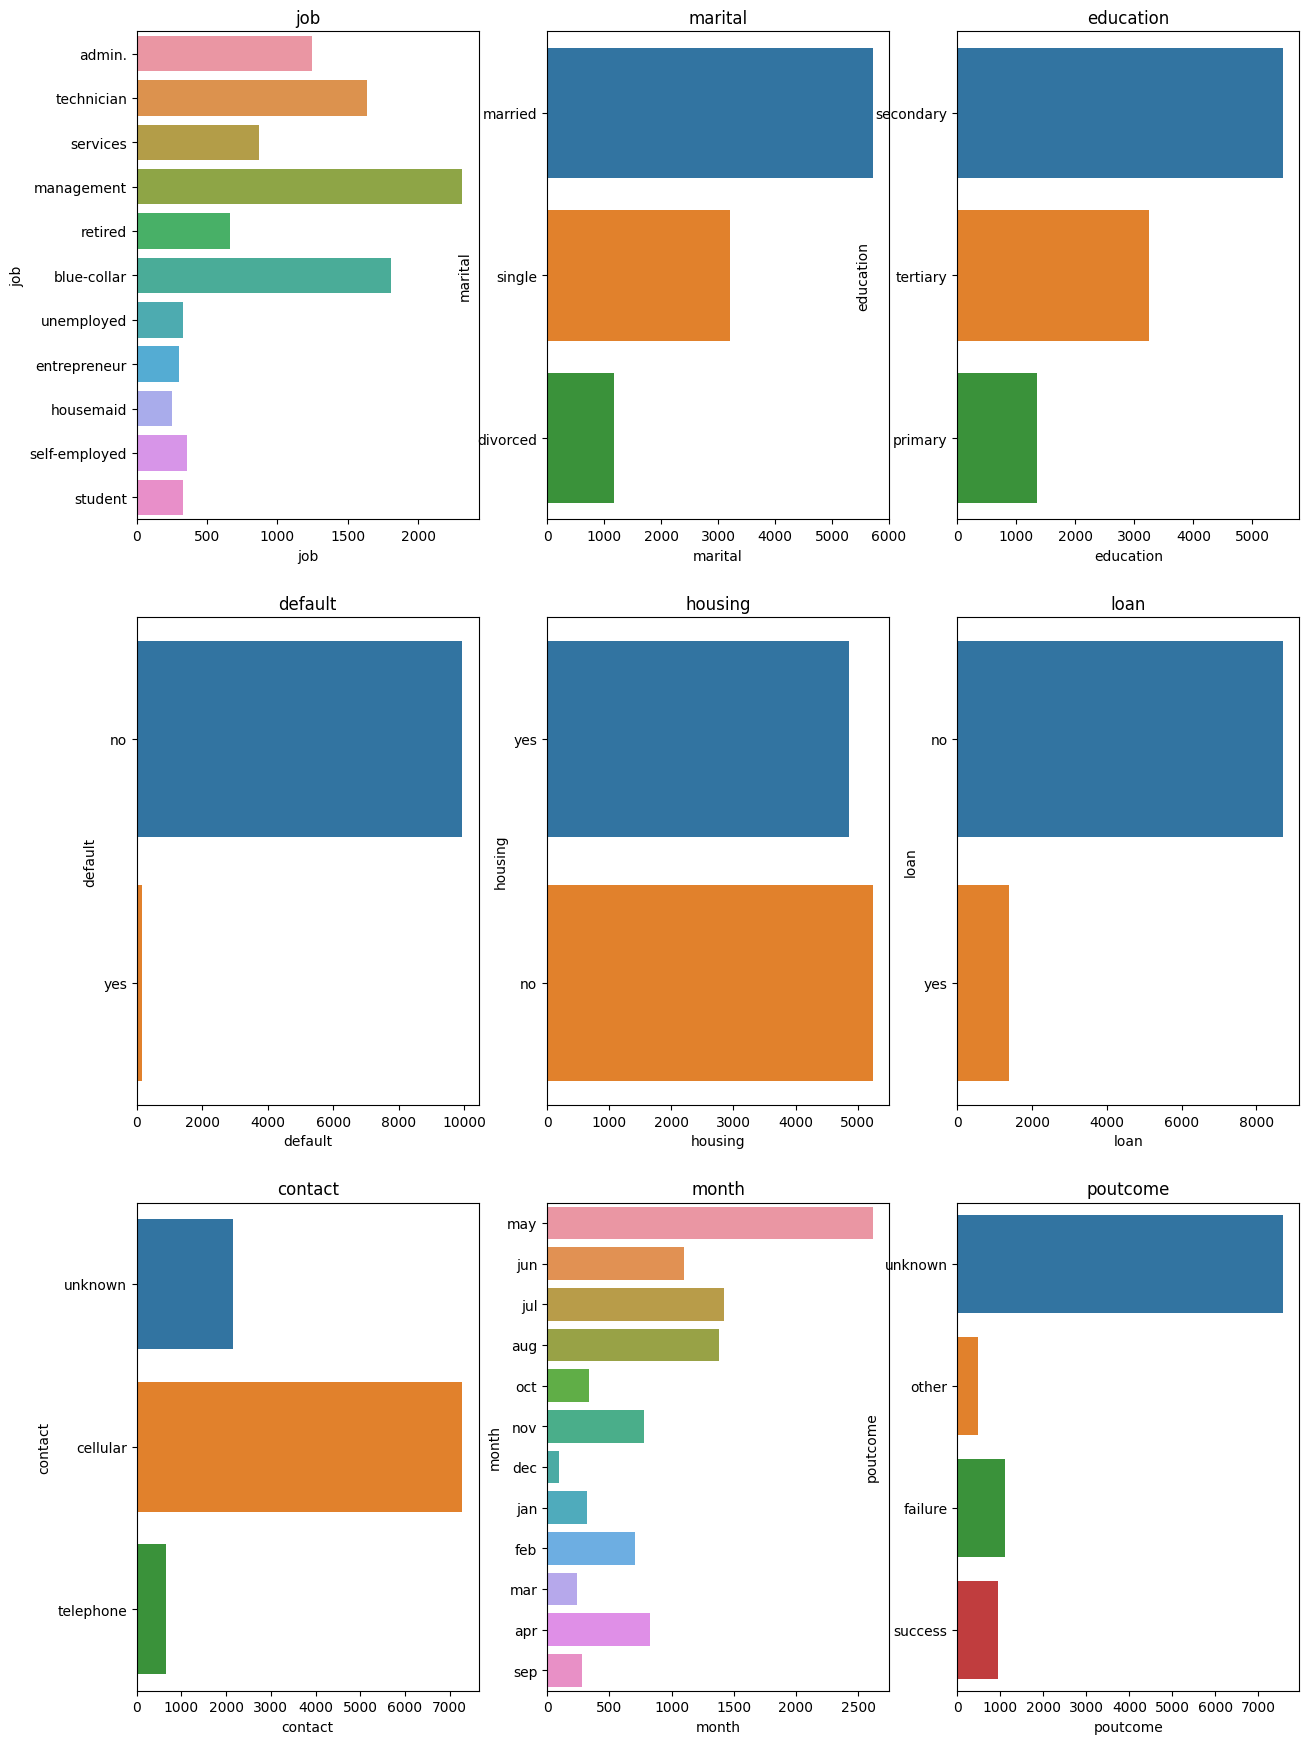

In [24]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты
df_nb.describe(include='object')
cat_features=[feature for feature in df_nb.columns if ((df_nb[feature].dtype=='O')&(feature not in ['deposit']))]
plt.figure(figsize=(15,90),facecolor='white')
plotnumber=1
for cat_feature in cat_features:
    ax=plt.subplot(12,3,plotnumber)
    sns.countplot(y=cat_feature,data=df_nb)
    plt.xlabel(cat_feature)
    plt.title(cat_feature)
    plotnumber+=1
plt.show()

### Задание 6

<Axes: xlabel='poutcome'>

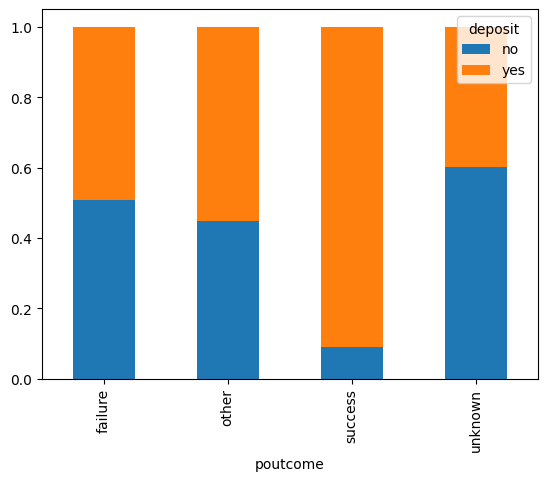

In [30]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
types=df_nb.groupby('poutcome')['deposit'].value_counts(normalize=True).unstack()
types.plot(kind='bar',stacked='True')

### Задание 7

<Axes: xlabel='month'>

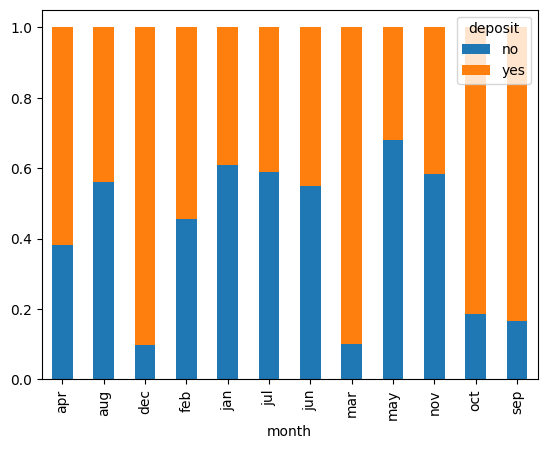

In [43]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
types=df_nb.groupby('month')['deposit'].value_counts(normalize=True).unstack()
types.plot(kind='bar',stacked='True')

### Задание 8

<Axes: xlabel='age_cat', ylabel='count'>

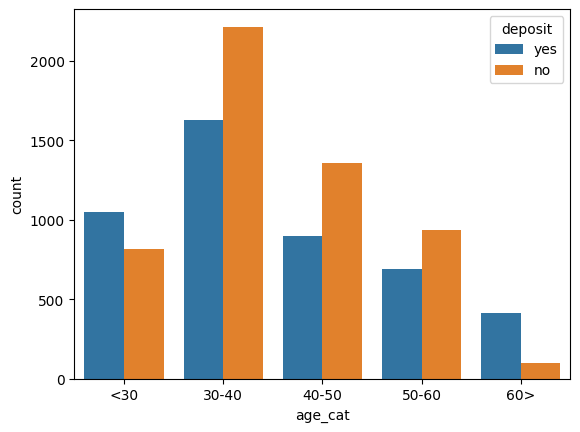

In [48]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df_nb['age_cat']=pd.cut(df_nb['age'],[0,30,40,50,60,99],labels=['<30','30-40','40-50','50-60','60>'])
sns.countplot(x='age_cat',hue='deposit',data=df_nb)

### Задания 9 и 10

<Axes: xlabel='count', ylabel='marital'>

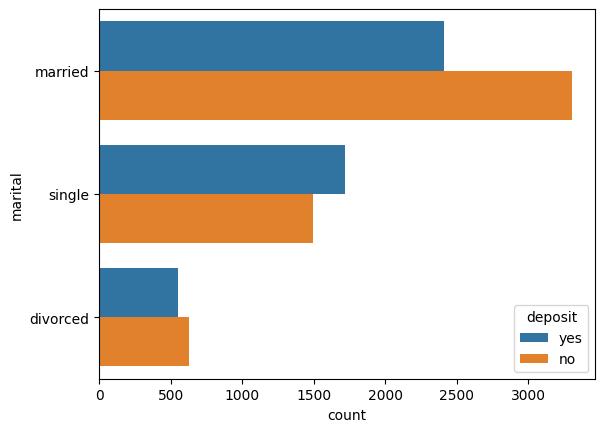

In [50]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital',hue='deposit',data=df_nb)

<Axes: xlabel='count', ylabel='education'>

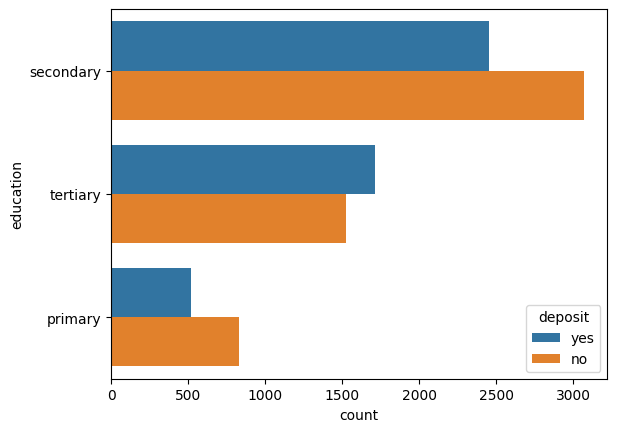

In [51]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y='education',hue='deposit',data=df_nb)

<Axes: xlabel='count', ylabel='job'>

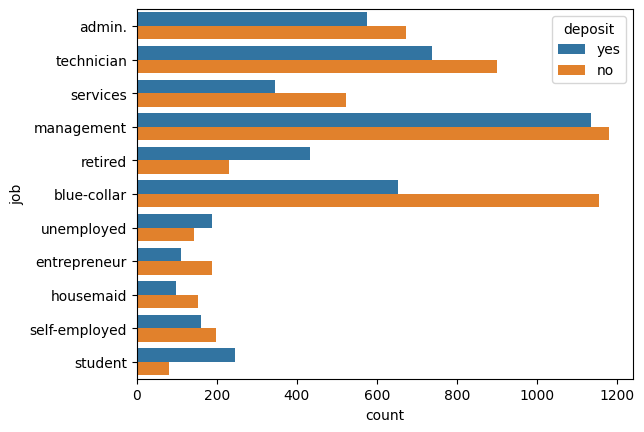

In [52]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y='job',hue='deposit',data=df_nb)

### Задание 11

In [60]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
tab1=df_nb[df_nb['deposit']=='no'][['marital','education','deposit']]
tab2=df_nb[df_nb['deposit']=='yes'][['marital','education','deposit']]
res1=pd.crosstab(tab1['education'],tab1['marital'])
res2=pd.crosstab(tab2['education'],tab2['marital'])
print(res1)
print(res2)

marital    divorced  married  single
education                           
primary          91      641     100
secondary       370     1830     866
tertiary        163      832     531
marital    divorced  married  single
education                           
primary          96      339      82
secondary       283     1289     879
tertiary        174      784     755


## Часть 3: преобразование данных

### Задание 1

In [61]:
# преобразуйте уровни образования
lab_enc=LabelEncoder()
df_nb['education']=lab_enc.fit_transform(df_nb['education'])
df_nb['education'].sum()

11995

### Задания 2 и 3

In [62]:
# преобразуйте бинарные переменные в представление из нулей и единиц
le=LabelEncoder()
df_nb['age_cat']=le.fit_transform(df_nb['age_cat'])

In [65]:
def new_binary(row):
    if row == 'yes':
        return 1
    else:
        return 0
    
df_nb['deposit']=df['deposit'].apply(new_binary)
df_nb['default']=df['default'].apply(new_binary)
df_nb['housing']=df['housing'].apply(new_binary)
df_nb['loan']=df['loan'].apply(new_binary)

In [67]:
round(df_nb.deposit.std(),3)

0.499

In [68]:
round(df_nb['default'].mean()+df_nb['loan'].mean()+df_nb['housing'].mean(),3)

0.635

### Задание 4

In [69]:
# создайте дамми-переменные
dum_list=['job','marital','contact','month','poutcome']
df_nb=pd.get_dummies(df_nb,columns=dum_list,prefix=dum_list)
df_nb

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,False,False,True,False,False,False,False,False,False,True
1,56,1,0,45.0,0,0,5,1467,1,-1,...,False,False,True,False,False,False,False,False,False,True
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,False,False,True,False,False,False,False,False,False,True
3,55,1,0,2476.0,1,0,5,579,1,-1,...,False,False,True,False,False,False,False,False,False,True
4,54,2,0,184.0,0,0,5,673,2,-1,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,0,1.0,1,0,20,257,1,-1,...,False,False,False,False,False,False,False,False,False,True
11158,39,1,0,733.0,0,0,16,83,4,-1,...,True,False,False,False,False,False,False,False,False,True
11159,32,1,0,29.0,0,0,19,156,2,-1,...,False,False,False,False,False,False,False,False,False,True
11160,43,1,0,0.0,0,1,8,9,2,172,...,False,False,True,False,False,False,True,False,False,False


### Задания 5 и 6

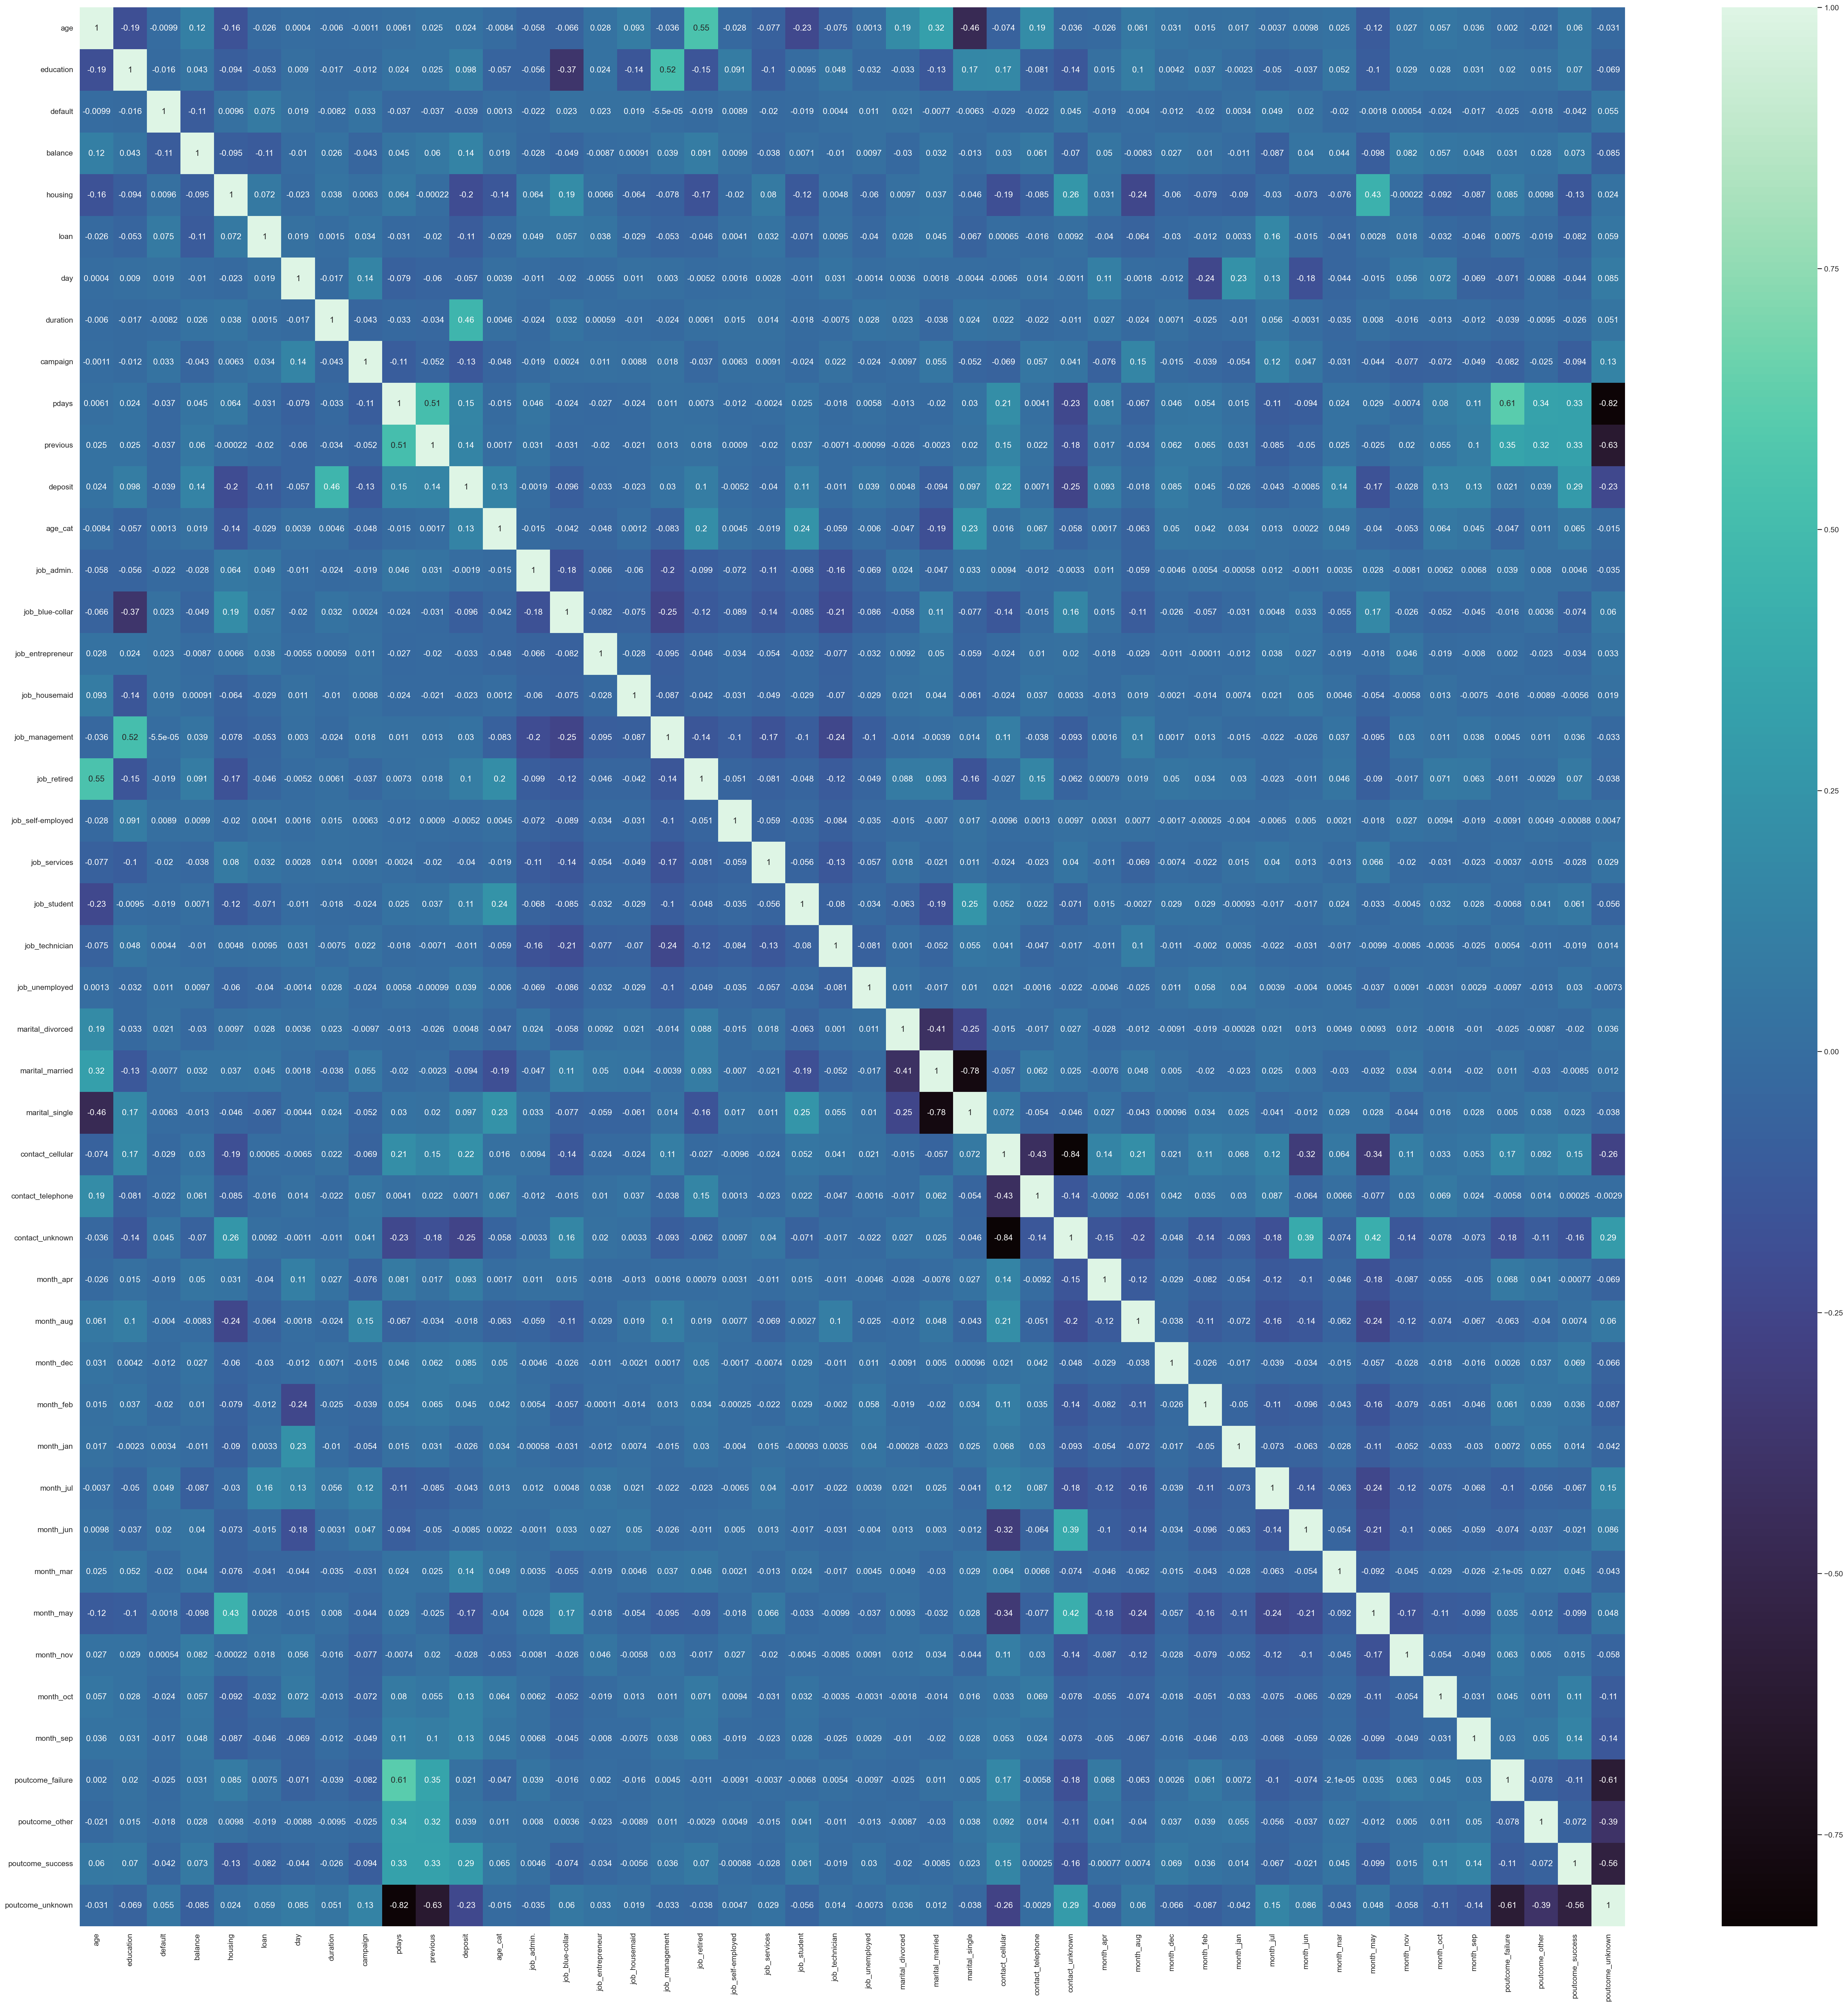

In [91]:
plt.figure(figsize = (50,50),dpi=150)
ax=sns.heatmap(df_nb.corr(),annot=True,cmap='mako')

### Задания 7 и 8

In [93]:
X = df_nb.drop(['deposit'], axis=1)
y = df_nb['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [96]:
X_test.shape
y_test.mean()

0.46326836581709147

### Задание 9

In [109]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif
select_kbest_class=SelectKBest(score_func=f_classif,k=15).fit(X_train,y_train)
select_kbest_class.get_support()
feature_names=list(X_train.columns.values)
mask=select_kbest_class.get_support()
new_features=[]
for bool,feature in zip (mask,feature_names):
    if bool:
        new_features.append(feature)
new_features.append('deposit')
new_features


['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_cat',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown',
 'deposit']

### Задание 10

In [110]:
# нормализуйте данные с помощью minmaxsxaler
df_final=df_nb[new_features]
X=df_final.drop(['deposit'],axis=1)
y=df_final['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [111]:
from sklearn.preprocessing import MinMaxScaler
mi_ma_scaler=MinMaxScaler()
mi_ma_scaler.fit(X_train)
X_train_scaled=mi_ma_scaler.transform(X_train)
X_test_scaled=mi_ma_scaler.transform(X_test)

In [116]:
round(X_test_scaled[:,0].mean(),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [117]:
# обучите логистическую регрессию и рассчитайте метрики качества
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
log_reg=LogisticRegression(random_state=42,max_iter=1000,solver='sag')
log_reg.fit(X_train_scaled,y_train)
y_train_pred=log_reg.predict(X_train_scaled)
y_test_pred=log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_train_pred,y_train))
print(metrics.classification_report(y_test_pred,y_test))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      3941
           1       0.76      0.84      0.80      2829

    accuracy                           0.82      6770
   macro avg       0.82      0.83      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1963
           1       0.74      0.83      0.78      1372

    accuracy                           0.81      3335
   macro avg       0.80      0.81      0.81      3335
weighted avg       0.82      0.81      0.81      3335



### Задания 2,3,4

In [125]:
# обучите решающие деревья, настройте максимальную глубину
from sklearn.tree import DecisionTreeClassifier
DT=DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=9)
DT.fit(X_train_scaled,y_train)
y_train_pred_DT=DT.predict(X_train_scaled)
y_test_pred_DT=DT.predict(X_test_scaled)
print(metrics.classification_report(y_train_pred_DT,y_train))
print(metrics.classification_report(y_test_pred_DT,y_test))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      3438
           1       0.87      0.82      0.84      3332

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1672
           1       0.83      0.77      0.80      1663

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [129]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
params={'min_samples_split': [2, 5, 7, 10],'max_depth':[3,5,7]}
model_cv=GridSearchCV(tree.DecisionTreeClassifier(),param_grid=params,cv=3,scoring='f1',return_train_score=True)
model_cv.fit(X_train_scaled,y_train)
y_test_pred_CV=model_cv.predict(X_test_scaled)
y_train_pred_CV=model_cv.predict(X_train_scaled)
print(metrics.classification_report(y_train_pred_CV,y_train))
print(metrics.classification_report(y_test_pred_CV,y_test))
print(model_cv.best_params_)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3609
           1       0.83      0.82      0.83      3161

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1737
           1       0.82      0.79      0.80      1598

    accuracy                           0.81      3335
   macro avg       0.82      0.81      0.81      3335
weighted avg       0.82      0.81      0.81      3335

{'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [130]:
# обучите на ваших данных случайный лес
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(n_estimators=100,criterion='gini',min_samples_leaf=5,max_depth=10,random_state=42)
RF.fit(X_train_scaled,y_train)
y_RF_test_pred=RF.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_RF_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [131]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
grad_mod=GradientBoostingClassifier(n_estimators=300,learning_rate=0.05,min_samples_leaf=5,max_depth=5,random_state=42)
grad_mod.fit(X_train_scaled,y_train)
y_grad_pred=grad_mod.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_grad_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [133]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
estimators=[('dt',DT),('lr',log_reg),('gb',grad_mod)]
stack=StackingClassifier(estimators=estimators,final_estimator=LogisticRegression(random_state=42))
stack.fit(X_train_scaled,y_train)
y_stack_pred=stack.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_stack_pred))
print(metrics.precision_score(y_test,y_stack_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

0.8093385214007782


### Задание 5

In [142]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
f_i=grad_mod.feature_importances_
print(np.sort(f_i)[::-1])

[0.50710587 0.11495825 0.07258213 0.05795212 0.05514176 0.04772538
 0.03989723 0.02781861 0.01988016 0.01521407 0.01478195 0.01352999
 0.00841131 0.00362013 0.00138103]


### Задания 6,7,8

In [146]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study()

study.optimize(optuna_rf, n_trials=10)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))


[I 2023-08-02 15:36:38,494] A new study created in memory with name: no-name-5435447d-96cd-40b2-93ec-59a04f543e9b
[I 2023-08-02 15:36:39,031] Trial 0 finished with value: 0.8794126835363948 and parameters: {'n_estimators': 159, 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8794126835363948.
[I 2023-08-02 15:36:39,533] Trial 1 finished with value: 0.8594653743942473 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8594653743942473.
[I 2023-08-02 15:36:40,062] Trial 2 finished with value: 0.8502506265664161 and parameters: {'n_estimators': 178, 'max_depth': 24, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8502506265664161.
[I 2023-08-02 15:36:40,493] Trial 3 finished with value: 0.8449600250823014 and parameters: {'n_estimators': 149, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8449600250823014.
[I 2023-08-02 15:36:40,917] Trial 4 finished with value: 0.84395604395604

accuracy на тестовом наборе: 0.821
f1_score на тестовом наборе: 0.810
